# Author: Damaris A. 

## Supporting Question: Influence of Dissolved Oxygen on Water Quality

### Import Libraries/Dataset

In [2]:
import zipfile
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [3]:
zip_file_path = "final_data/narrowresult.zip"

with zipfile.ZipFile(zip_file_path, 'r') as z:
    file_names = z.namelist()
    
    csv_file_name = [name for name in file_names if name.endswith('.csv')][0]
    
    with z.open(csv_file_name) as f:
        df = pd.read_csv(f)


df.head()

/tmp/ipykernel_72/1034000686.py:9: DtypeWarning: Columns (10,13,15,19,20,22,31,33,34,36,38,40,43,48,60,64,65,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,CALWR_WQX,California Department Of Water Resources,CALWR_WQX-BL13B658987,2013-05-07,10:45:00,PST,CALWR_WQX-B9D75841349,STORET-476204739,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,CEDEN,California State Water Resources Control Board,CEDEN--2146157048,2013-04-29,13:00:00,PST,CEDEN-207R00271,STORET-560281410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21CABCH,Southern California Coastal Water Research Pro...,21CABCH-ENCINAL BEACH SOUTH-4/29/2013,2013-04-29,NaN,NaN,21CABCH-ENCINAL BEACH SOUTH,STORET-283378496,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,CEDEN,California State Water Resources Control Board,CEDEN--2146149071,2013-05-20,09:15:00,PST,CEDEN-SMC4.34,STORET-832636092,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,CEDEN,California State Water Resources Control Board,CEDEN--2145498327,2013-05-22,10:02:00,PST,CEDEN-202R00280,STORET-832787370,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET


### Understanding the Dataset

In [4]:
df.isnull().sum()

OrganizationIdentifier                       0
OrganizationFormalName                       0
ActivityIdentifier                           0
ActivityStartDate                            0
ActivityStartTime/Time                   69268
                                         ...  
LaboratoryAccreditationAuthorityName    676186
TaxonomistAccreditationIndicator        676186
TaxonomistAccreditationAuthorityName    676186
LabSamplePreparationUrl                 676186
ProviderName                                 0
Length: 78, dtype: int64

In [5]:
# Fill missing values in the 'ActivityStartTime/Time' column
df['ActivityStartTime/Time'] = df['ActivityStartTime/Time'].ffill()

# Fill missing values in the 'ActivityStartTime/TimeZoneCode' column
df['ActivityStartTime/TimeZoneCode'] = df['ActivityStartTime/TimeZoneCode'].fillna('Unknown')

In [6]:
df.columns[df.columns.str.contains('LaboratoryAccreditation', case=False)]

Index(['LaboratoryAccreditationIndicator', 'LaboratoryAccreditationAuthorityName'], dtype='object')

In [7]:
# impute missing values 
df['LaboratoryAccreditationIndicator'] = df['LaboratoryAccreditationIndicator'].fillna('Unknown')
df['ResultLaboratoryCommentText'] = df['ResultLaboratoryCommentText'].fillna('Unknown')
df['ResultDetectionQuantitationLimitUrl'] = df['ResultDetectionQuantitationLimitUrl'].fillna('Unknown')
df['TaxonomistAccreditationAuthorityName'] = df['TaxonomistAccreditationAuthorityName'].fillna('Unknown')
df.isnull().sum()

OrganizationIdentifier                       0
OrganizationFormalName                       0
ActivityIdentifier                           0
ActivityStartDate                            0
ActivityStartTime/Time                       0
                                         ...  
LaboratoryAccreditationAuthorityName    676186
TaxonomistAccreditationIndicator        676186
TaxonomistAccreditationAuthorityName         0
LabSamplePreparationUrl                 676186
ProviderName                                 0
Length: 78, dtype: int64

In [8]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

In [9]:
# Drop columns with excessive missing values (e.g., >50% missing)
df_cleaned = df.loc[:, df.isnull().mean() < 0.5]

# Verify the remaining missing values
print(df_cleaned.isnull().sum())

OrganizationIdentifier                                 0
OrganizationFormalName                                 0
ActivityIdentifier                                     0
ActivityStartDate                                      0
ActivityStartTime/Time                                 0
ActivityStartTime/TimeZoneCode                         0
MonitoringLocationIdentifier                           0
ResultIdentifier                                       0
CharacteristicName                                     0
ResultMeasureValue                                111626
ResultMeasure/MeasureUnitCode                     168697
ResultStatusIdentifier                                 0
ResultValueTypeName                                    0
ResultAnalyticalMethod/MethodIdentifier           228455
ResultAnalyticalMethod/MethodIdentifierContext    228455
ResultAnalyticalMethod/MethodName                 228506
ResultLaboratoryCommentText                            0
ResultDetectionQuantitationLimi

In [10]:
# Impute missing categorical columns with 'Unknown'
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns
df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna('Unknown')

# Impute missing numerical columns with the median
# numeric_columns = df_cleaned.select_dtypes(include=['number']).columns
# df_cleaned[numeric_columns] = df_cleaned[numeric_columns].fillna(df_cleaned[numeric_columns].median())

# Verify the remaining missing values
print(df_cleaned.isnull().sum())

/tmp/ipykernel_72/286795560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[categorical_columns] = df_cleaned[categorical_columns].fillna('Unknown')


OrganizationIdentifier                            0
OrganizationFormalName                            0
ActivityIdentifier                                0
ActivityStartDate                                 0
ActivityStartTime/Time                            0
ActivityStartTime/TimeZoneCode                    0
MonitoringLocationIdentifier                      0
ResultIdentifier                                  0
CharacteristicName                                0
ResultMeasureValue                                0
ResultMeasure/MeasureUnitCode                     0
ResultStatusIdentifier                            0
ResultValueTypeName                               0
ResultAnalyticalMethod/MethodIdentifier           0
ResultAnalyticalMethod/MethodIdentifierContext    0
ResultAnalyticalMethod/MethodName                 0
ResultLaboratoryCommentText                       0
ResultDetectionQuantitationLimitUrl               0
LaboratoryAccreditationIndicator                  0
TaxonomistAc

In [11]:
# Check the shape and data types after cleaning
print(df_cleaned.shape)
print(df_cleaned.dtypes)

(676186, 21)
OrganizationIdentifier                            object
OrganizationFormalName                            object
ActivityIdentifier                                object
ActivityStartDate                                 object
ActivityStartTime/Time                            object
ActivityStartTime/TimeZoneCode                    object
MonitoringLocationIdentifier                      object
ResultIdentifier                                  object
CharacteristicName                                object
ResultMeasureValue                                object
ResultMeasure/MeasureUnitCode                     object
ResultStatusIdentifier                            object
ResultValueTypeName                               object
ResultAnalyticalMethod/MethodIdentifier           object
ResultAnalyticalMethod/MethodIdentifierContext    object
ResultAnalyticalMethod/MethodName                 object
ResultLaboratoryCommentText                       object
ResultDetectionQua

In [12]:
df.isnull().sum()

OrganizationIdentifier                       0
OrganizationFormalName                       0
ActivityIdentifier                           0
ActivityStartDate                            0
ActivityStartTime/Time                       0
                                         ...  
LaboratoryAccreditationAuthorityName    676186
TaxonomistAccreditationIndicator        676186
TaxonomistAccreditationAuthorityName         0
LabSamplePreparationUrl                 676186
ProviderName                                 0
Length: 78, dtype: int64

In [13]:
df_cleaned = df_cleaned.drop_duplicates()

In [14]:
# Numeric columns ResultMeasureValue change to be in a numerical type float64
df_cleaned['ResultMeasureValue'] = pd.to_numeric(df_cleaned['ResultMeasureValue'], errors='coerce')

In [15]:
#Outliers detecting 
Q1 = df_cleaned['ResultMeasureValue'].quantile(0.25)
Q3 = df_cleaned['ResultMeasureValue'].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df_cleaned[(df_cleaned['ResultMeasureValue'] >= (Q1 - 1.5 * IQR)) & 
                        (df_cleaned['ResultMeasureValue'] <= (Q3 + 1.5 * IQR))]

In [16]:
df_cleaned['ActivityStartDate']

0         2013-05-07
1         2013-04-29
2         2013-04-29
3         2013-05-20
5         2013-03-19
             ...    
676181    2023-10-17
676182    2023-10-17
676183    2023-10-17
676184    2023-10-17
676185    2023-10-17
Name: ActivityStartDate, Length: 469762, dtype: object

In [17]:
#feature engineering 
df_cleaned['ActivityStartDate'] = pd.to_datetime(df['ActivityStartDate'], errors='coerce')
df_cleaned['Year'] = df_cleaned['ActivityStartDate'].dt.year
df_cleaned['Month'] = df_cleaned['ActivityStartDate'].dt.month
df_cleaned['Day'] = df_cleaned['ActivityStartDate'].dt.day
df_cleaned['Weekday'] = df_cleaned['ActivityStartDate'].dt.weekday
df_cleaned['Hour'] = df_cleaned['ActivityStartDate'].dt.hour

In [18]:
#remove irrelevant columns
df_cleaned = df_cleaned.drop(columns=['ActivityStartTime/TimeZoneCode', 'ResultLaboratoryCommentText'])

In [19]:
# Define the most relevant characteristics for predicting DO levels
relevant_characteristics = [
    'Dissolved oxygen (DO)', 'Temperature, water', 'pH', 'Specific conductance',
    'Turbidity', 'Nitrate', 'Ammonia', 'Chlorophyll a', 'Flow'
]

# Filter the data based on the most relevant characteristics
filtered_data = df_cleaned[df_cleaned['CharacteristicName'].isin(relevant_characteristics)]

# Print the first few rows of the filtered data
filtered_data.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,MonitoringLocationIdentifier,ResultIdentifier,CharacteristicName,ResultMeasureValue,ResultMeasure/MeasureUnitCode,...,ResultAnalyticalMethod/MethodName,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,TaxonomistAccreditationAuthorityName,ProviderName,Year,Month,Day,Weekday,Hour
29,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-SFAN_I&M_GG1_20130408_F^01,2013-04-08,12:30:00,11NPSWRD_WQX-SFAN_I&M_GG1,STORET-974332184,pH,7.68,Unknown,...,YSI Professional Plus (Pro Plus) Multiparamete...,Unknown,Unknown,Unknown,STORET,2013,4,8,0,0
61,CALWR_WQX,California Department Of Water Resources,CALWR_WQX-BL13B656485,2013-04-02,11:45:00,CALWR_WQX-B9C75861385,STORET-476356332,Turbidity,0.00,NTU,...,Turbidity by Nephelometry,https://www.waterqualitydata.us/data/providers...,Unknown,Unknown,STORET,2013,4,2,1,0
72,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-PRSF_WQ_EL1_20130717_F^02,2013-07-17,11:50:00,11NPSWRD_WQX-PRSF_WQ_EL1,STORET-974378107,Turbidity,8.77,NTU,...,Determination of Turbidity,https://www.waterqualitydata.us/data/providers...,Unknown,Unknown,STORET,2013,7,17,2,0
81,CALWR_WQX,California Department Of Water Resources,CALWR_WQX-CFF0413B0116,2013-04-18,10:45:00,CALWR_WQX-B9D75861372,STORET-476701319,pH,9.36,Unknown,...,pH,Unknown,Unknown,Unknown,STORET,2013,4,18,3,0
83,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-PORE_WQ_PAC1B_20130219_F^01,2013-02-19,09:50:00,11NPSWRD_WQX-PORE_WQ_PAC1B,STORET-974483117,pH,6.76,Unknown,...,pH,Unknown,Unknown,Unknown,STORET,2013,2,19,1,0


In [20]:
# Display the first few rows of the filtered dataset to ensure it contains the right data
print(filtered_data[['CharacteristicName', 'ResultMeasureValue']].head())

# Check for unique characteristic names to ensure the relevant ones are in the dataset
print(filtered_data['CharacteristicName'].unique())

   CharacteristicName  ResultMeasureValue
29                 pH                7.68
61          Turbidity                0.00
72          Turbidity                8.77
81                 pH                9.36
83                 pH                6.76
['pH' 'Turbidity' 'Dissolved oxygen (DO)' 'Temperature, water' 'Ammonia'
 'Chlorophyll a' 'Nitrate' 'Flow' 'Specific conductance']


In [21]:
# Convert 'ResultMeasureValue' to numeric, coercing errors to NaN
filtered_data['ResultMeasureValue'] = pd.to_numeric(filtered_data['ResultMeasureValue'], errors='coerce')

# Pivot data to get each characteristic as a separate column
pivot_data = filtered_data.pivot_table(
    index=['MonitoringLocationIdentifier', 'ActivityStartDate', 'Month', 'Year',],
    columns='CharacteristicName',
    values='ResultMeasureValue'
).reset_index()

# Check for missing values
print(pivot_data.isnull().sum())
pivot_data.head()

CharacteristicName
MonitoringLocationIdentifier        0
ActivityStartDate                   0
Month                               0
Year                                0
Ammonia                         11485
Chlorophyll a                   11835
Dissolved oxygen (DO)            8204
Flow                            13264
Nitrate                          7541
Specific conductance            13366
Temperature, water               4077
Turbidity                        8059
pH                               5167
dtype: int64


/tmp/ipykernel_72/676873980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ResultMeasureValue'] = pd.to_numeric(filtered_data['ResultMeasureValue'], errors='coerce')


CharacteristicName,MonitoringLocationIdentifier,ActivityStartDate,Month,Year,Ammonia,Chlorophyll a,Dissolved oxygen (DO),Flow,Nitrate,Specific conductance,"Temperature, water",Turbidity,pH
0,11NPSWRD_WQX-PORE_319_EU-L,2012-01-23,1,2012,NaN,NaN,10.730,17.8106,0.20,95.40,10.8,40.6,7.00
1,11NPSWRD_WQX-PORE_319_EU-L,2012-03-13,3,2012,NaN,NaN,9.265,0.2295,0.22,108.25,10.1,NaN,6.63
2,11NPSWRD_WQX-PORE_319_EU-L,2012-03-27,3,2012,NaN,NaN,10.740,1.7280,NaN,107.20,9.8,15.7,7.03
3,11NPSWRD_WQX-PORE_319_EU-L,2012-04-12,4,2012,NaN,NaN,10.700,1.7172,NaN,106.50,10.5,12.3,7.18
4,11NPSWRD_WQX-PORE_319_EU-L,2012-11-28,11,2012,NaN,NaN,8.370,NaN,0.55,NaN,12.8,12.4,6.99


### EDA

In [22]:
pivot_data.head()

CharacteristicName,MonitoringLocationIdentifier,ActivityStartDate,Month,Year,Ammonia,Chlorophyll a,Dissolved oxygen (DO),Flow,Nitrate,Specific conductance,"Temperature, water",Turbidity,pH
0,11NPSWRD_WQX-PORE_319_EU-L,2012-01-23,1,2012,NaN,NaN,10.730,17.8106,0.20,95.40,10.8,40.6,7.00
1,11NPSWRD_WQX-PORE_319_EU-L,2012-03-13,3,2012,NaN,NaN,9.265,0.2295,0.22,108.25,10.1,NaN,6.63
2,11NPSWRD_WQX-PORE_319_EU-L,2012-03-27,3,2012,NaN,NaN,10.740,1.7280,NaN,107.20,9.8,15.7,7.03
3,11NPSWRD_WQX-PORE_319_EU-L,2012-04-12,4,2012,NaN,NaN,10.700,1.7172,NaN,106.50,10.5,12.3,7.18
4,11NPSWRD_WQX-PORE_319_EU-L,2012-11-28,11,2012,NaN,NaN,8.370,NaN,0.55,NaN,12.8,12.4,6.99


In [23]:
pivot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13577 entries, 0 to 13576
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   MonitoringLocationIdentifier  13577 non-null  object        
 1   ActivityStartDate             13577 non-null  datetime64[ns]
 2   Month                         13577 non-null  int32         
 3   Year                          13577 non-null  int32         
 4   Ammonia                       2092 non-null   float64       
 5   Chlorophyll a                 1742 non-null   float64       
 6   Dissolved oxygen (DO)         5373 non-null   float64       
 7   Flow                          313 non-null    float64       
 8   Nitrate                       6036 non-null   float64       
 9   Specific conductance          211 non-null    float64       
 10  Temperature, water            9500 non-null   float64       
 11  Turbidity                   

In [24]:
pivot_data.describe()

CharacteristicName,ActivityStartDate,Month,Year,Ammonia,Chlorophyll a,Dissolved oxygen (DO),Flow,Nitrate,Specific conductance,"Temperature, water",Turbidity,pH
count,13577,13577.000000,13577.000000,2092.000000,1742.000000,5373.000000,313.000000,6036.000000,211.000000,9500.000000,5518.000000,8410.000000
mean,2015-07-23 05:20:37.475141632,6.130294,2015.093172,0.225572,8.714344,8.423823,5.115390,1.649115,93.778057,14.450922,9.438026,7.693300
min,2010-01-04 00:00:00,1.000000,2010.000000,-0.500000,-54.401200,0.060000,0.000459,-0.170000,0.800000,0.300000,0.000000,2.500000
25%,2012-05-16 00:00:00,3.000000,2012.000000,0.036000,0.038000,7.080000,0.522000,0.220000,84.550000,11.400000,1.160000,7.400000
50%,2015-01-21 00:00:00,6.000000,2015.000000,0.100000,3.200000,8.860000,2.150000,0.644250,99.600000,13.827500,3.380000,7.690000
75%,2018-02-21 00:00:00,9.000000,2018.000000,0.225000,8.000000,10.090000,3.029000,1.700000,107.650000,16.800000,10.000000,8.000000
max,2023-12-12 00:00:00,12.000000,2023.000000,14.538016,114.000000,105.800000,88.000000,44.000000,114.400000,71.260000,114.000000,16.600000
std,NaN,3.345840,3.723968,0.522846,16.806705,3.251518,11.165790,3.155853,19.644438,4.278682,15.940132,0.509176


In [25]:
pivot_data.columns

Index(['MonitoringLocationIdentifier', 'ActivityStartDate', 'Month', 'Year',
       'Ammonia', 'Chlorophyll a', 'Dissolved oxygen (DO)', 'Flow', 'Nitrate',
       'Specific conductance', 'Temperature, water', 'Turbidity', 'pH'],
      dtype='object', name='CharacteristicName')

In [26]:
pivot_data.loc[:, 'ActivityStartDate'] = pd.to_datetime(pivot_data['ActivityStartDate'])
pivot_data = pivot_data.copy()
pivot_data['ActivityStartDate'] = pd.to_datetime(pivot_data['ActivityStartDate'])

In [27]:
# Overview of the data
print("Dataset Shape:", pivot_data.shape)
print("\nSummary Statistics:")
print(pivot_data.describe())

# Checking missing values
print("\nMissing Values (%):")
print(pivot_data.isnull().mean() * 100)

# Unique values for categorical columns
categorical_columns = pivot_data.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"{col}: {pivot_data[col].nunique()} unique values")

Dataset Shape: (13577, 13)

Summary Statistics:
CharacteristicName              ActivityStartDate         Month          Year  \
count                                       13577  13577.000000  13577.000000   
mean                2015-07-23 05:20:37.475141632      6.130294   2015.093172   
min                           2010-01-04 00:00:00      1.000000   2010.000000   
25%                           2012-05-16 00:00:00      3.000000   2012.000000   
50%                           2015-01-21 00:00:00      6.000000   2015.000000   
75%                           2018-02-21 00:00:00      9.000000   2018.000000   
max                           2023-12-12 00:00:00     12.000000   2023.000000   
std                                           NaN      3.345840      3.723968   

CharacteristicName      Ammonia  Chlorophyll a  Dissolved oxygen (DO)  \
count               2092.000000    1742.000000            5373.000000   
mean                   0.225572       8.714344               8.423823   
min

In [28]:
# delete all rows that do not have a value for Dissolved Oxygen
filtered_pivot_data = pivot_data.dropna(subset=['Dissolved oxygen (DO)'])

# Check the new shape of the data
print(f"Original data shape: {pivot_data.shape}")
print(f"Filtered data shape: {filtered_pivot_data.shape}")

Original data shape: (13577, 13)
Filtered data shape: (5373, 13)


In [29]:
filtered_pivot_data.drop(columns=['Flow', 'Specific conductance', 'Ammonia', 'Chlorophyll a'], inplace=True)

/tmp/ipykernel_72/1219704392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pivot_data.drop(columns=['Flow', 'Specific conductance', 'Ammonia', 'Chlorophyll a'], inplace=True)


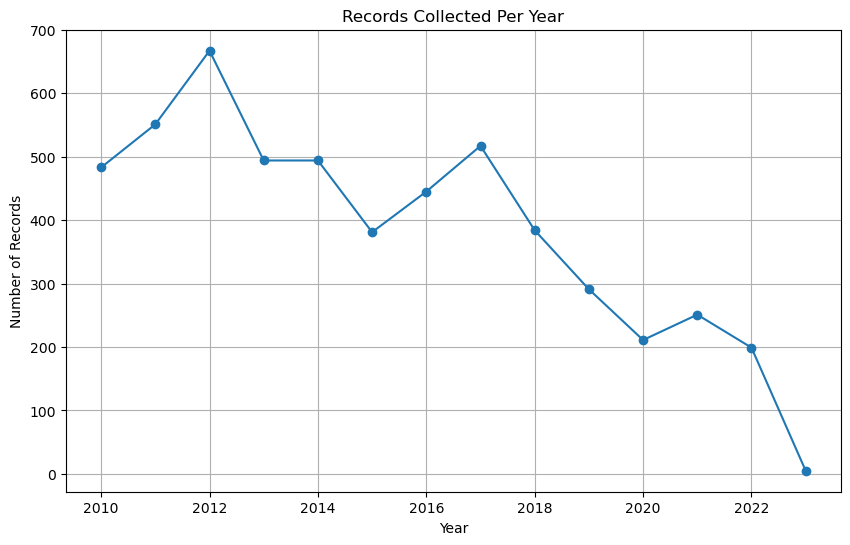

In [30]:
yearly_counts = filtered_pivot_data['Year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o')
plt.title('Records Collected Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.grid(True)
plt.show()

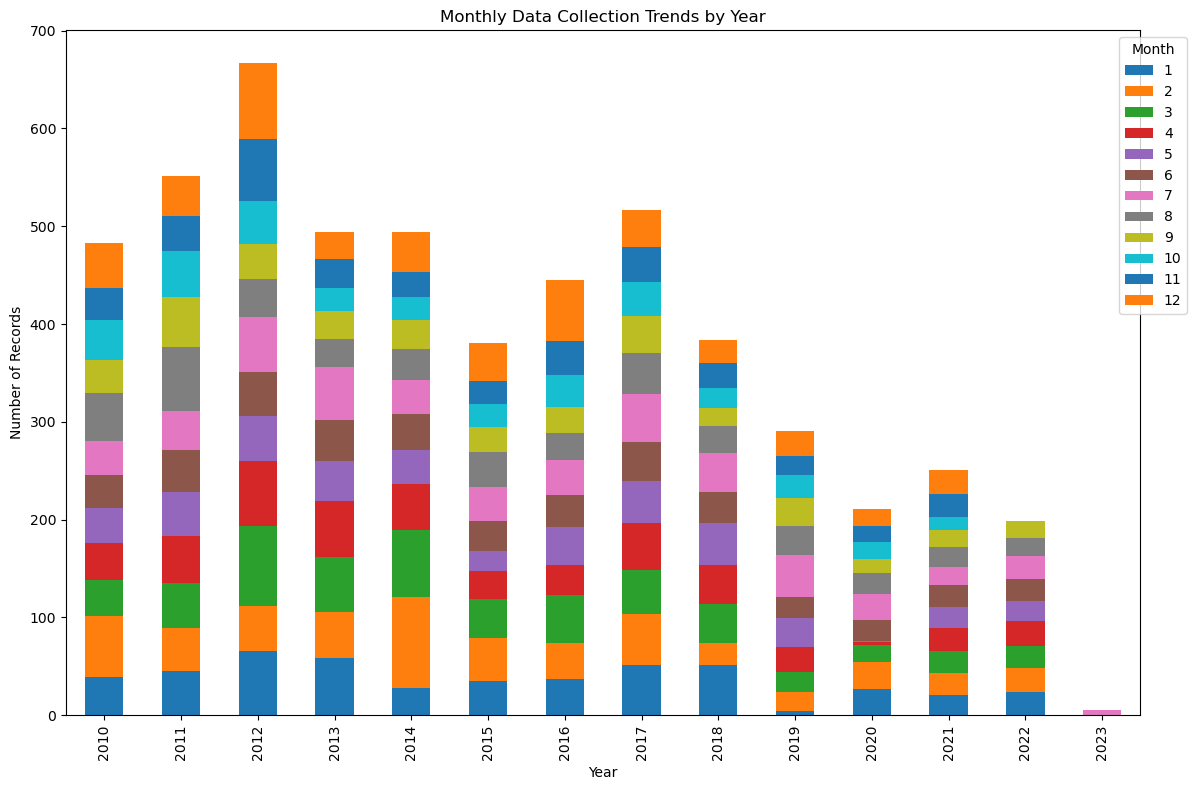

In [31]:
monthly_counts = filtered_pivot_data.groupby(['Year', 'Month']).size().unstack()
monthly_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Monthly Data Collection Trends by Year')
plt.xlabel('Year')
plt.ylabel('Number of Records')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Forecasting and Prediction Modeling 

In [32]:
# Inspect unique values in 'CharacteristicName' after cleaning
filtered_pivot_data.head()

CharacteristicName,MonitoringLocationIdentifier,ActivityStartDate,Month,Year,Dissolved oxygen (DO),Nitrate,"Temperature, water",Turbidity,pH
0,11NPSWRD_WQX-PORE_319_EU-L,2012-01-23,1,2012,10.730,0.20,10.8,40.6,7.00
1,11NPSWRD_WQX-PORE_319_EU-L,2012-03-13,3,2012,9.265,0.22,10.1,NaN,6.63
2,11NPSWRD_WQX-PORE_319_EU-L,2012-03-27,3,2012,10.740,NaN,9.8,15.7,7.03
3,11NPSWRD_WQX-PORE_319_EU-L,2012-04-12,4,2012,10.700,NaN,10.5,12.3,7.18
4,11NPSWRD_WQX-PORE_319_EU-L,2012-11-28,11,2012,8.370,0.55,12.8,12.4,6.99


## Impute Missing Values

### Mean Imputing certain Columns(do not have extreme outliers)

In [55]:
filtered_pivot_data.loc[:, 'Temperature, water'] = filtered_pivot_data['Temperature, water'].fillna(
    filtered_pivot_data['Temperature, water'].mean()
)


### Median Imputing certain Columns(have extreme outliers)

In [56]:
filtered_pivot_data.loc[:, 'Nitrate'] = filtered_pivot_data['Nitrate'].fillna(filtered_pivot_data['Nitrate'].median())
filtered_pivot_data.loc[:, 'Turbidity'] = filtered_pivot_data['Turbidity'].fillna(filtered_pivot_data['Turbidity'].median())
filtered_pivot_data.loc[:, 'pH'] = filtered_pivot_data['pH'].fillna(filtered_pivot_data['pH'].median())


### KNN Imputing DO since it's time dependent and prediction target variable so important

In [58]:
knn_imputer = KNNImputer(n_neighbors=5)
imputed_values = knn_imputer.fit_transform(filtered_pivot_data[['Temperature, water', 'Turbidity', 'pH', 'Nitrate']])
filtered_pivot_data.loc[:, 'Dissolved oxygen (DO)'] = imputed_values[:, 0]  # Assuming the imputed values are for the first column

In [59]:
print(filtered_pivot_data.isnull().sum())

CharacteristicName
MonitoringLocationIdentifier    0
ActivityStartDate               0
Month                           0
Year                            0
Dissolved oxygen (DO)           0
Nitrate                         0
Temperature, water              0
Turbidity                       0
pH                              0
DO_lag1                         0
Temp_lag1                       0
Turb_lag1                       0
pH_lag1                         0
dtype: int64


### Doing the Models

In [60]:
features = ['Temperature, water', 'Turbidity', 'pH', 'Year', 'Month', 'Nitrate']
target = 'Dissolved oxygen (DO)'

In [62]:
filtered_pivot_data.loc[:, 'DO_lag1'] = filtered_pivot_data.groupby('MonitoringLocationIdentifier')[target].shift(1)
filtered_pivot_data.loc[:, 'Temp_lag1'] = filtered_pivot_data.groupby('MonitoringLocationIdentifier')['Temperature, water'].shift(1)
filtered_pivot_data.loc[:, 'Turb_lag1'] = filtered_pivot_data.groupby('MonitoringLocationIdentifier')['Turbidity'].shift(1)
filtered_pivot_data.loc[:, 'pH_lag1'] = filtered_pivot_data.groupby('MonitoringLocationIdentifier')['pH'].shift(1)


In [63]:
filtered_pivot_data = filtered_pivot_data.dropna(subset=['DO_lag1', 'Temp_lag1', 'Turb_lag1', 'pH_lag1'])


In [64]:
filtered_pivot_data.head()

CharacteristicName,MonitoringLocationIdentifier,ActivityStartDate,Month,Year,Dissolved oxygen (DO),Nitrate,"Temperature, water",Turbidity,pH,DO_lag1,Temp_lag1,Turb_lag1,pH_lag1
3,11NPSWRD_WQX-PORE_319_EU-L,2012-04-12,4,2012,10.5,0.62,10.5,12.3,7.18,9.8,9.8,15.7,7.03
4,11NPSWRD_WQX-PORE_319_EU-L,2012-11-28,11,2012,12.8,0.55,12.8,12.4,6.99,10.5,10.5,12.3,7.18
5,11NPSWRD_WQX-PORE_319_EU-L,2012-12-21,12,2012,10.4,0.62,10.4,19.0,6.96,12.8,12.8,12.4,6.99
8,11NPSWRD_WQX-PORE_319_EU-L,2014-02-27,2,2014,11.2,0.16,11.2,14.0,6.58,10.4,10.4,19.0,6.96
9,11NPSWRD_WQX-PORE_319_EU-L,2014-02-28,2,2014,11.4,0.62,11.4,14.0,6.56,11.2,11.2,14.0,6.58


In [65]:
X = filtered_pivot_data[features + ['DO_lag1', 'Temp_lag1', 'Turb_lag1', 'pH_lag1']]
y = filtered_pivot_data[target]
# Train-test split (e.g., 80% for training, 20% for testing)
train_size = int(len(filtered_pivot_data) * 0.8)
train_data, test_data = filtered_pivot_data[:train_size], filtered_pivot_data[train_size:]

In [66]:
X_train, X_test = train_data[features + ['DO_lag1', 'Temp_lag1', 'Turb_lag1', 'pH_lag1']], test_data[features + ['DO_lag1', 'Temp_lag1', 'Turb_lag1', 'pH_lag1']]
y_train, y_test = train_data[target], test_data[target]

## Linear Regression

In [67]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)

In [68]:
# Model 2: Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)


In [69]:
# Model 3: XGBoost Regressor
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)
xgb_regressor.fit(X_train, y_train)
y_pred_xgb = xgb_regressor.predict(X_test)

In [70]:
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

In [71]:
print("Linear Regression Evaluation:")
print(evaluate_model(y_test, y_pred_lin_reg))

print("Random Forest Evaluation:")
print(evaluate_model(y_test, y_pred_rf))

print("XGBoost Evaluation:")
print(evaluate_model(y_test, y_pred_xgb))

Linear Regression Evaluation:
(3.917602265237813e-15, 2.563965428360055e-29, 1.0)
Random Forest Evaluation:
(0.005158415258862304, 0.006375617505986919, 0.9988075210054891)
XGBoost Evaluation:
(0.0406434035526217, 0.01589218846679683, 0.9970275662074036)


### Visualize Models

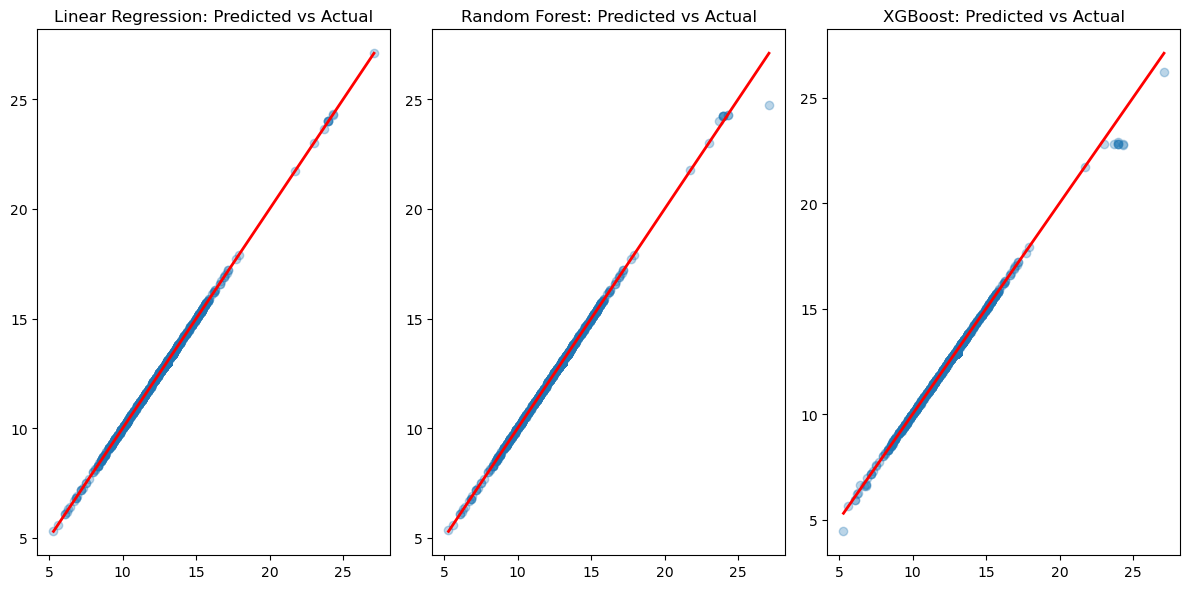

In [72]:
linear_pred = lin_reg.predict(X_test)
rf_pred = rf_regressor.predict(X_test)
xgb_pred = xgb_regressor.predict(X_test)

plt.figure(figsize=(12, 6))

# Linear Regression
plt.subplot(1, 3, 1)
plt.scatter(y_test, linear_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Linear Regression: Predicted vs Actual')

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, rf_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Random Forest: Predicted vs Actual')

# XGBoost
plt.subplot(1, 3, 3)
plt.scatter(y_test, xgb_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('XGBoost: Predicted vs Actual')

plt.tight_layout()
plt.show()